In [1]:
%pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage

In [6]:
FLIGHT_SALES_PATH = '/home/chk/Documents/univ/maestria/dataton/Datathon/flight_sales.csv'

In [7]:
dtype_options = {
    'Unnamed: 0': 'int64',
    'Flight_ID': 'str',
    'ProductType': 'str',
    'ProductName': 'str',
    'Quantity': 'float64',
    'TotalSales': 'float64',
    'Aeronave': 'str',
    'DepartureStation': 'str',
    'ArrivalStation': 'str',
    'DestinationType': 'str',
    'Origin_Type': 'str',
    'Capacity': 'float64',
    'Passengers': 'float64',
    'Bookings': 'float64'
}

parse_dates = ['STD', 'STA']

flightSales = pd.read_csv(FLIGHT_SALES_PATH, dtype=dtype_options, parse_dates=parse_dates)
flightSales['STD'] = pd.to_datetime(flightSales['STD'])
flightSales['STA'] = pd.to_datetime(flightSales['STA'])
flightSales.head()

,Unnamed: 0,Flight_ID,ProductType,ProductName,Quantity,TotalSales,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings
0,0,a05290288259526edd3601160b10e1de,Botanas,Carne Seca Habanero,1.0,55.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
1,1,a05290288259526edd3601160b10e1de,Botanas,Cheetos,2.0,98.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
2,2,a05290288259526edd3601160b10e1de,Botanas,Ruffles Queso,6.0,294.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
3,3,a05290288259526edd3601160b10e1de,Refrescos,Coca Sin Azucar,2.0,96.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0
4,4,a05290288259526edd3601160b10e1de,Licores,Jack And Coke,1.0,72.0,XA-VIQ,AW,AO,Ciudad Principal,Ciudad Principal,2023-08-28 19:20:00,2023-08-28 20:45:00,186.0,131.0,100.0


In [149]:
flightSales['Duration'] = (flightSales['STA'] - flightSales['STD']).dt.total_seconds() / 3600
flightSales['TravelType'] = flightSales['Duration'].apply(lambda x: 'corto' if x < 2.5 else 'largo')
flightSales['PassengerRate'] = flightSales['Passengers'] / flightSales['Capacity'] * 100

In [150]:
flightSales['BuyRate'] = flightSales['Quantity'] / flightSales['Passengers'] * 100

In [152]:
sales2 = flightSales.groupby(['Origin_Type', 'Destination_Type', 'TravelType', 'STD', 'ProductType']).agg({
    'BuyRate': 'mean',
    'Duration': 'mean'
})
sales2.reset_index(inplace=True)
sales2.rename(columns={'STD': 'ds', 'BuyRate': 'y'}, inplace=True)
sales2

,Origin_Type,Destination_Type,TravelType,ds,ProductType,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,Bebidas Calientes,1.453488,2.0
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,Botanas,1.453488,2.0
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,Galletas,0.581395,2.0
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,Licores,0.581395,2.0
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,Perecederos,1.744186,2.0
...,...,...,...,...,...,...,...
580537,Playa,Playa,largo,2023-10-22 08:55:00,Lacteos,1.149425,3.5
580538,Playa,Playa,largo,2023-10-22 08:55:00,Licores,0.862069,3.5
580539,Playa,Playa,largo,2023-10-22 08:55:00,Perecederos,1.149425,3.5
580540,Playa,Playa,largo,2023-10-22 08:55:00,Refrescos,1.609195,3.5


In [9]:
salesGrouped = flightSales.groupby(['Origin_Type', 'Destination_Type', 'TravelType', 'STD']).agg({
    'PassengerRate': 'mean',
    'Duration': 'mean'
})
salesGrouped.reset_index(inplace=True)
salesGrouped.rename(columns={'STD': 'ds', 'PassengerRate': 'y'}, inplace=True)
salesGrouped

,Origin_Type,Destination_Type,TravelType,ds,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,78.181818,2.0
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-03 16:40:00,96.666667,2.0
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-05 16:40:00,87.222222,2.0
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-06 09:20:00,57.727273,2.0
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-07 16:40:00,72.580645,2.0
...,...,...,...,...,...,...
227212,Playa,Playa,largo,2023-10-15 08:55:00,94.444444,3.5
227213,Playa,Playa,largo,2023-10-19 21:05:00,76.881720,3.5
227214,Playa,Playa,largo,2023-10-22 08:55:00,93.548387,3.5
227215,Playa,Playa,largo,2024-04-08 20:45:00,NaN,3.5


In [130]:
salesGrouped = salesGrouped[~salesGrouped['y'].isnull()]
salesGrouped

,Origin_Type,Destination_Type,TravelType,ds,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,78.181818,2.0
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-03 16:40:00,96.666667,2.0
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-05 16:40:00,87.222222,2.0
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-06 09:20:00,57.727273,2.0
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-07 16:40:00,72.580645,2.0
...,...,...,...,...,...,...
227210,Playa,Playa,largo,2023-10-08 08:55:00,93.333333,3.5
227211,Playa,Playa,largo,2023-10-12 21:05:00,81.720430,3.5
227212,Playa,Playa,largo,2023-10-15 08:55:00,94.444444,3.5
227213,Playa,Playa,largo,2023-10-19 21:05:00,76.881720,3.5


In [131]:
tscv = TimeSeriesSplit()

# for train_index, val_index in tscv.split(salesGrouped):
#     train_df = salesGrouped.iloc[train_index]
#     val_df = salesGrouped.iloc[val_index]

train_index, val_index = next(tscv.split(salesGrouped))
train_df = salesGrouped.iloc[train_index]
val_df = salesGrouped.iloc[val_index]

In [3]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [133]:
unique_combinations

,Origin_Type,Destination_Type,TravelType
0,Ciudad Fronteriza,Ciudad Principal,corto
2218,Ciudad Fronteriza,Ciudad Principal,largo
14698,Ciudad Fronteriza,Ecoturismo,largo
15102,Ciudad Fronteriza,MX Amigos y Familia,corto
16464,Ciudad Fronteriza,MX Amigos y Familia,largo
19406,Ciudad Fronteriza,Playa,corto
20835,Ciudad Fronteriza,Playa,largo
23865,Ciudad Principal,Ciudad Fronteriza,corto
34248,Ciudad Principal,Ciudad Fronteriza,largo
38165,Ciudad Principal,Ciudad Principal,corto


In [132]:
group_attributes = ['Origin_Type', 'Destination_Type', 'TravelType']
unique_combinations = salesGrouped[group_attributes].drop_duplicates()
preds = list()
train = pd.DataFrame()
validations = pd.DataFrame()

for _, row in unique_combinations.iterrows():
    condicion = (salesGrouped[group_attributes] == row[group_attributes]).all(axis=1)
    filtered_df = salesGrouped[condicion]
    train_index, val_index = next(tscv.split(filtered_df))
    train_df = salesGrouped.iloc[train_index]
    val_df = salesGrouped.iloc[val_index]
    validations = pd.concat([validations, val_df], ignore_index=True)
    train = pd.concat([train, train_df], ignore_index=True)

    m = Prophet(seasonality_mode='additive', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True)
    m.fit(train_df)

    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['Origin_Type'] = row['Origin_Type']
    forecast['Destination_Type'] = row['Destination_Type']
    forecast['TravelType'] = row['TravelType']
    preds.append(forecast[['Origin_Type', 'Destination_Type', 'TravelType', 'ds', 'yhat']])

preds = pd.concat(preds, ignore_index=True)
preds['yhat'] = preds['yhat'].clip(lower=0)
preds = preds.merge(validations, on=['Origin_Type', 'Destination_Type', 'TravelType', 'ds'], how='left')
wmape(preds['y'], preds['yhat'])

09:28:40 - cmdstanpy - INFO - Chain [1] start processing
09:28:40 - cmdstanpy - INFO - Chain [1] done processing
09:28:41 - cmdstanpy - INFO - Chain [1] start processing
09:28:41 - cmdstanpy - INFO - Chain [1] done processing
09:28:41 - cmdstanpy - INFO - Chain [1] start processing
09:28:42 - cmdstanpy - INFO - Chain [1] done processing
09:28:42 - cmdstanpy - INFO - Chain [1] start processing
09:28:42 - cmdstanpy - INFO - Chain [1] done processing
09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing
09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing
09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing
09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing
09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1]

0.1805123394460986

In [156]:
group_attributes = ['Origin_Type', 'Destination_Type', 'TravelType', 'ProductType']
unique_combinations = sales2[group_attributes].drop_duplicates()
preds = list()
train = pd.DataFrame()
validations = pd.DataFrame()

for _, row in unique_combinations.iterrows():
    condicion = (sales2[group_attributes] == row[group_attributes]).all(axis=1)
    filtered_df = sales2[condicion]
    try:
        train_index, val_index = next(tscv.split(filtered_df))
    except:
        continue
    train_df = sales2.iloc[train_index]
    val_df = sales2.iloc[val_index]
    validations = pd.concat([validations, val_df], ignore_index=True)
    train = pd.concat([train, train_df], ignore_index=True)

    m = Prophet(seasonality_mode='additive', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True)
    try:
        m.fit(train_df)
    except:
        continue

    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['Origin_Type'] = row['Origin_Type']
    forecast['Destination_Type'] = row['Destination_Type']
    forecast['TravelType'] = row['TravelType']
    forecast['ProductType'] = row['ProductType']
    preds.append(forecast[['Origin_Type', 'Destination_Type', 'TravelType', 'ProductType', 'ds', 'yhat']])

preds = pd.concat(preds, ignore_index=True)
preds['yhat'] = preds['yhat'].clip(lower=0)
preds = preds.merge(validations, on=['Origin_Type', 'Destination_Type', 'TravelType', 'ProductType', 'ds'], how='left')
wmape(preds['y'], preds['yhat'])

10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1]

0.4610342746343042

In [157]:
preds

,Origin_Type,Destination_Type,TravelType,ProductType,ds,yhat,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-02 09:20:00,1.494863,NaN,NaN
1,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0
2,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0
3,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0
4,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0
...,...,...,...,...,...,...,...,...
138106,Playa,Playa,largo,Licores,2024-01-01 16:40:00,4.302512,NaN,NaN
138107,Playa,Playa,largo,Licores,2024-01-02 16:40:00,4.058452,NaN,NaN
138108,Playa,Playa,largo,Licores,2024-01-03 16:40:00,4.271040,NaN,NaN
138109,Playa,Playa,largo,Licores,2024-01-04 16:40:00,4.647837,NaN,NaN


In [142]:
preds2 = preds
preds2['ds'] = preds2['ds'].astype(str)
vals2 = validations

preds2 = preds2.merge(vals2, on=['Origin_Type', 'Destination_Type', 'TravelType', 'ds'], how='left')

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [134]:
preds

,Origin_Type,Destination_Type,TravelType,ds,yhat,y,Duration
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-02 09:20:00,56.326640,NaN,NaN
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-03 16:40:00,76.335039,NaN,NaN
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-05 16:40:00,92.344090,NaN,NaN
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-06 09:20:00,74.740570,NaN,NaN
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-07 16:40:00,76.648999,NaN,NaN
...,...,...,...,...,...,...,...
34443,Playa,Playa,largo,2024-01-14 09:20:00,1938.884151,NaN,NaN
34444,Playa,Playa,largo,2024-01-15 09:20:00,1920.758951,NaN,NaN
34445,Playa,Playa,largo,2024-01-16 09:20:00,2378.531739,NaN,NaN
34446,Playa,Playa,largo,2024-01-17 09:20:00,1933.989192,NaN,NaN


In [88]:
wmape(preds['y'], preds['yhat'])

0.15349938496058643

In [92]:
train['unique_id'] = train['Origin_Type'] + '-' + train['Destination_Type'] + '-' + train['TravelType']
validations['unique_id'] = validations['Origin_Type'] + '-' + validations['Destination_Type'] + '-' + validations['TravelType']

In [93]:
naive_model = StatsForecast(models=[Naive(),
                                    SeasonalNaive(season_length=365),
                                    WindowAverage(window_size=365),
                                    SeasonalWindowAverage(window_size=7, season_length=365)],
                                    freq='H',
                                    n_jobs=-1)
naive_model.fit(train[['unique_id', 'ds', 'y']])

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA])

In [97]:
p_naive = naive_model.predict(h=validations['ds'].nunique())
valid2 = validations
valid2['ds'] = validations['ds'].dt.round('H').astype(str)
p_naive['ds'] = p_naive['ds'].dt.round('H').astype(str)
p_naive = p_naive.reset_index().merge(valid2, on=['unique_id', 'ds'], how='left')


/home/chk/.local/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [98]:
validations

,Origin_Type,Destination_Type,TravelType,ds,y,Duration,unique_id
0,Ciudad Fronteriza,Ciudad Principal,corto,2023-05-22 10:00:00,66.129032,2.150000,Ciudad Fronteriza-Ciudad Principal-corto
1,Ciudad Fronteriza,Ciudad Principal,corto,2023-05-22 15:00:00,72.916667,0.916667,Ciudad Fronteriza-Ciudad Principal-corto
2,Ciudad Fronteriza,Ciudad Principal,corto,2023-05-22 21:00:00,47.777778,2.150000,Ciudad Fronteriza-Ciudad Principal-corto
3,Ciudad Fronteriza,Ciudad Principal,corto,2023-05-22 22:00:00,87.727273,1.750000,Ciudad Fronteriza-Ciudad Principal-corto
4,Ciudad Fronteriza,Ciudad Principal,corto,2023-05-23 09:00:00,78.181818,1.750000,Ciudad Fronteriza-Ciudad Principal-corto
...,...,...,...,...,...,...,...
37853,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-30 09:00:00,24.090909,2.000000,Ciudad Fronteriza-Ciudad Principal-corto
37854,Ciudad Fronteriza,Ciudad Principal,corto,2023-01-31 17:00:00,58.636364,2.000000,Ciudad Fronteriza-Ciudad Principal-corto
37855,Ciudad Fronteriza,Ciudad Principal,corto,2023-02-01 09:00:00,26.666667,2.000000,Ciudad Fronteriza-Ciudad Principal-corto
37856,Ciudad Fronteriza,Ciudad Principal,corto,2023-02-02 17:00:00,73.888889,2.000000,Ciudad Fronteriza-Ciudad Principal-corto


In [99]:
p_naive

,unique_id,ds,Naive,SeasonalNaive,WindowAverage,SeasWA,Origin_Type,Destination_Type,TravelType,y,Duration
0,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ciudad Fronteriza-Ciudad Principal-corto,2025-01-30 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23082,Ciudad Fronteriza-Ciudad Principal-largo,2024-02-02 08:00:00,78.494621,80.0,82.486717,78.629036,Ciudad Fronteriza,Ciudad Principal,largo,NaN,3.166667
23083,Ciudad Fronteriza-Ciudad Principal-largo,2024-02-02 08:00:00,78.494621,80.0,82.486717,78.629036,Ciudad Fronteriza,Ciudad Principal,largo,NaN,4.666667
23084,Ciudad Fronteriza-Ciudad Principal-largo,2024-02-02 08:00:00,78.494621,80.0,82.486717,78.629036,Ciudad Fronteriza,Ciudad Principal,largo,NaN,5.333333
23085,Ciudad Fronteriza-Ciudad Principal-largo,2024-02-02 09:00:00,78.494621,80.0,82.486717,77.408882,Ciudad Fronteriza,Ciudad Principal,largo,NaN,3.583333


In [100]:
p_naive['y'].isnull().sum()

10584

In [107]:
p2 = p_naive[~p_naive['Naive'].isnull()]
p2 = p2[~p2['y'].isnull()]

In [112]:
p2

,unique_id,ds,Naive,SeasonalNaive,WindowAverage,SeasWA,Origin_Type,Destination_Type,TravelType,y,Duration
6157,Ciudad Fronteriza-Ciudad Principal-largo,2023-05-21 21:00:00,78.494621,78.888885,82.486717,78.085754,Ciudad Fronteriza,Ciudad Principal,largo,89.166667,4.500000
6158,Ciudad Fronteriza-Ciudad Principal-largo,2023-05-21 21:00:00,78.494621,78.888885,82.486717,78.085754,Ciudad Fronteriza,Ciudad Principal,largo,89.166667,4.500000
6159,Ciudad Fronteriza-Ciudad Principal-largo,2023-05-21 21:00:00,78.494621,78.888885,82.486717,78.085754,Ciudad Fronteriza,Ciudad Principal,largo,89.166667,4.500000
6160,Ciudad Fronteriza-Ciudad Principal-largo,2023-05-21 21:00:00,78.494621,78.888885,82.486717,78.085754,Ciudad Fronteriza,Ciudad Principal,largo,89.166667,4.500000
6161,Ciudad Fronteriza-Ciudad Principal-largo,2023-05-21 21:00:00,78.494621,78.888885,82.486717,78.085754,Ciudad Fronteriza,Ciudad Principal,largo,89.166667,4.500000
...,...,...,...,...,...,...,...,...,...,...,...
21415,Ciudad Fronteriza-Ciudad Principal-largo,2023-12-31 23:00:00,78.494621,82.916664,82.486717,78.352089,Ciudad Fronteriza,Ciudad Principal,largo,70.430108,5.416667
21416,Ciudad Fronteriza-Ciudad Principal-largo,2024-01-01 00:00:00,78.494621,97.849464,82.486717,85.046082,Ciudad Fronteriza,Ciudad Principal,largo,90.322581,4.916667
21417,Ciudad Fronteriza-Ciudad Principal-largo,2024-01-01 00:00:00,78.494621,97.849464,82.486717,85.046082,Ciudad Fronteriza,Ciudad Principal,largo,67.083333,5.416667
21419,Ciudad Fronteriza-Ciudad Principal-largo,2024-01-01 00:00:00,78.494621,97.849464,82.486717,85.046082,Ciudad Fronteriza,Ciudad Principal,largo,90.322581,4.916667


In [108]:
wmape(p2['y'], p2['SeasonalNaive'])

0.17627064615526966

In [122]:
p = p2

In [158]:
p = preds

In [165]:
p['unique_id'] = p['Origin_Type'] + '-' + p['Destination_Type'] + '-' + p['TravelType'] + '-' + p['ProductType']


In [166]:
p = p[~p['yhat'].isnull()]
p = p[~p['y'].isnull()]

In [167]:
p['y'].values

array([0.57471264, 0.57471264, 0.57471264, ..., 0.57803468, 0.57803468,
       0.57803468])

In [168]:
p

,Origin_Type,Destination_Type,TravelType,ProductType,ds,yhat,y,Duration,unique_id
1,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Bebid...
2,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Bebid...
3,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Bebid...
4,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Bebid...
5,Ciudad Fronteriza,Ciudad Principal,corto,Bebidas Calientes,2023-01-03 16:40:00,1.162443,0.574713,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Bebid...
...,...,...,...,...,...,...,...,...,...
14841,Ciudad Fronteriza,Ciudad Principal,corto,Lacteos,2023-02-11 16:45:00,0.479430,0.578035,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Lacteos
14842,Ciudad Fronteriza,Ciudad Principal,corto,Lacteos,2023-02-11 16:45:00,0.479430,0.578035,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Lacteos
14843,Ciudad Fronteriza,Ciudad Principal,corto,Lacteos,2023-02-11 16:45:00,0.479430,0.578035,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Lacteos
14844,Ciudad Fronteriza,Ciudad Principal,corto,Lacteos,2023-02-11 16:45:00,0.479430,0.578035,2.0,Ciudad Fronteriza-Ciudad Principal-corto-Lacteos


In [182]:
p['unique_id'].unique()

array(['Ciudad Fronteriza-Ciudad Principal-corto-Bebidas Calientes',
       'Ciudad Fronteriza-Ciudad Principal-corto-Botanas',
       'Ciudad Fronteriza-Ciudad Principal-corto-Galletas',
       'Ciudad Fronteriza-Ciudad Principal-corto-Licores',
       'Ciudad Fronteriza-Ciudad Principal-corto-Perecederos',
       'Ciudad Fronteriza-Ciudad Principal-corto-Refrescos',
       'Ciudad Fronteriza-Ciudad Principal-corto-Sopas',
       'Ciudad Fronteriza-Ciudad Principal-corto-Lacteos'], dtype=object)

In [ ]:
# 'Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA'

yhat WMAPE: 46.10%


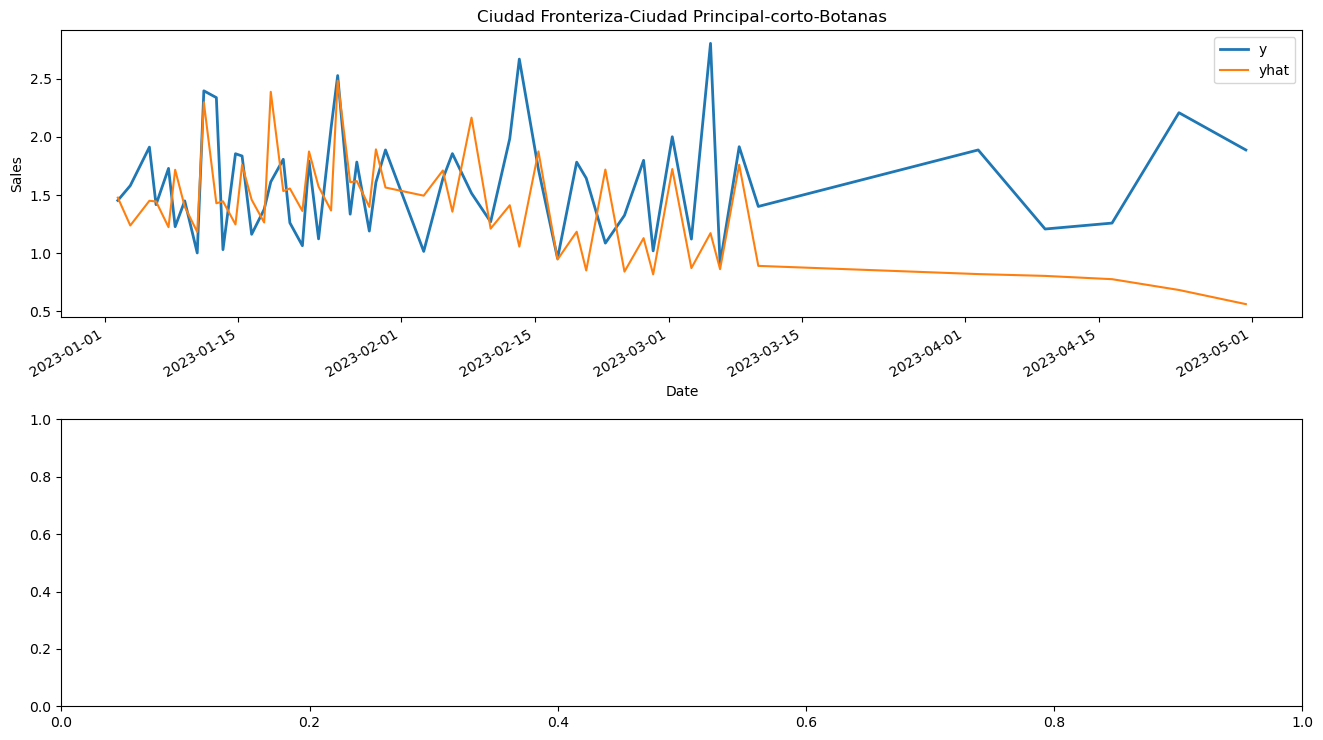

In [189]:
minmape = 100000000000
idmape = -1
for model_ in ['yhat']:
    fig,ax = plt.subplots(2,1, figsize=(1280/96, 720/96))
    for family in ['Ciudad Fronteriza-Ciudad Principal-corto-Botanas']:
    # for family in p['unique_id'].unique():
        ax_ = 0
        p.loc[p['unique_id'] == family].plot(x='ds', y='y', ax=ax[ax_], label='y', title=family, linewidth=2)
        p.loc[p['unique_id'] == family].plot(x='ds', y=model_, ax=ax[ax_], label=model_)
        # print(wmape(p.loc[p['unique_id'] == family]['y'].values, p.loc[p['unique_id'] == family]['yhat'].values))
        actmape = wmape(p.loc[p['unique_id'] == family]['y'].values, p.loc[p['unique_id'] == family]['yhat'].values)
        if actmape < minmape:
            minmape = actmape
            idmape = family
        ax[ax_].set_xlabel('Date')
        ax[ax_].set_ylabel('Sales')
        if model_ in ['Naive', 'SeasonalNaive']:
            # ax[ax_].fill_between(p.loc[p['unique_id'] == family, 'ds'].values,
                                # p.loc[p['unique_id'] == family, f'{model_}-lo-90'], 
                                # p.loc[p['unique_id'] == family, f'{model_}-hi-90'], 
                                # alpha=0.2,
                                # color='orange')
            ax[ax_].set_title(f'{family} - Orange band: 90% confidence interval')
        ax[ax_].legend()
    fig.tight_layout()
    wmape_ = wmape(p['y'].values, p[model_].values)
    print(f'{model_} WMAPE: {wmape_:.2%}')

In [188]:
idmape

'Ciudad Fronteriza-Ciudad Principal-corto-Botanas'